In [7]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
try:
  import google.colab
except ImportError:
  from dolfin import *
else:
  try:
    from dolfin import *
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
%matplotlib inline

In [8]:
# 1. Time and space discretisation 
# Space discretisation: Read the mesh for this problem

!wget "https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip" -O "/tmp/github_files.zip"

zip_ref = zipfile.ZipFile("/tmp/github_files.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

mesh = Mesh("/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data_square/mesh.xml")
subdomains = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data_square/mesh_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data_square/mesh_facet_region.xml")

dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)

dx_left = dx(1) #Subdomain 1
dx_right = dx(2) #Subdomain 2

ds_left = ds(1) #Left boundary
ds_left_bottom = ds(2) #Left bottom boundary
ds_right_bottom = ds(3) #Right bottom boundary
ds_right = ds(4) #Right boundary
ds_right_top = ds(5) #Right top boundary
ds_left_top = ds(6) #Left top boundary

# Time discretisation
t_max = 2.
num_steps = 100
dt = t_max/num_steps

--2022-08-26 23:27:19--  https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main [following]
--2022-08-26 23:27:19--  https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3160791 (3.0M) [application/zip]
Saving to: ‘/tmp/github_files.zip’

/tmp/github_files.z 100%[===================>]   3.01M  --.-KB/s    in 0.06s   

2022-08-26 23:27:19 (51.7 MB/s) - ‘/tmp/github_files.zip’ saved [3160791/3160791]



In [9]:
# 2. Create Finite Element space (Lagrange P1)
VT = FunctionSpace(mesh,"CG",1) # Space for temperature field
T_, psi = TrialFunction(VT), TestFunction(VT)
T = Function(VT,name="Temperature") # Temperature field at current time step
T_previous = interpolate(Constant(300.),VT) # Temperature field at previous time step

if VT.ufl_element().degree() == 1:
  VQ = VectorFunctionSpace(mesh,"CG",VT.ufl_element().degree()) # Space for heat flux
else:
  VQ = VectorFunctionSpace(mesh,"CG",VT.ufl_element().degree()-1) # Space for heat flux
q_, psi_q = TrialFunction(VQ), TestFunction(VQ)
q = Function(VQ,name="Heat flux") # Heat flux at current time step

In [10]:
# 3. Material and boundary properties, Source term
k_left, rho_left, heat_capacity_left = 10., 1., 1. # Thermal conductivity, density, heat capacity for subdomain 1
k_right, rho_right, heat_capacity_right = as_tensor([[15.,0.],[0.,5.]]), 1., 1. # Thermal conductivity, density, heat capacity for subdomain 2
h_left = 100. # Convection coefficient on left boundary
h_right = 50. # Convection coefficient on right boundary
T_left = Expression("300.+600.*t",degree=2,t=0) # Temperature on left boundary at current time step
T_left_previous = Expression("300.+600.*t",degree=2,t=0) # Temperature on left boundary at previous time step
T_right = Expression("300.+0*t",degree=2,t=0) # Temperature on right boundary at current time step
T_right_previous = Expression("300.+0*t",degree=2,t=0) # Temperature on right boundary at previous time step
Q = Expression("0*t",degree=1,t=0.) # Heat source at current time step
Q_previous = Expression("0*t",degree=1,t=0.) # Heat source at previous time step

In [11]:
# 4. Compute heat flux

def compute_heat_flux(temp_field):
  '''
  Compute the heat flux at given temperature field
  Input:
  temp_field: Function over Functionspace
  Output:
  q: Function over VectorFunctionSpace
  '''
  a_q = inner(q_, psi_q) * dx_left + inner(q_, psi_q) * dx_right
  l_q = inner(-k_left * grad(temp_field), psi_q) * dx_left + inner(-k_right * grad(temp_field), psi_q) * dx_right
  solve(a_q == l_q, q)
  return q

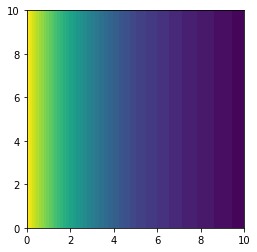

In [12]:
# 5. Weak formulation with generalised-$\theta$ method in time
theta = Constant(1.) # theta=0 means forward difference and theta=1 means backward difference

F_T = \
psi * rho_left * heat_capacity_left * T_ * dx_left + psi * rho_right * heat_capacity_right * T_ * dx_right - \
psi * rho_left * heat_capacity_left * T_previous * dx_left - psi * rho_right * heat_capacity_right * T_previous * dx_right

F_T_backward = \
dt * inner(k_left * grad(T_), grad(psi)) * dx_left + dt * inner(k_right * grad(T_), grad(psi)) * dx_right + \
dt * psi * h_left * (T_ - T_left) * ds_left + dt * psi * h_right * (T_ - T_right) * ds_right - \
psi * dt * Q * dx_left - psi * dt * Q * dx_right

F_T_forward = \
dt * inner(k_left * grad(T_previous), grad(psi)) * dx_left + dt * inner(k_right * grad(T_previous), grad(psi)) * dx_right + \
dt * psi * h_left * (T_previous - T_left_previous) * ds_left + dt * psi * h_right * (T_previous - T_right_previous) * ds_right - \
psi * dt * Q_previous * dx_left - psi * dt * Q_previous * dx_right

a_T = lhs(F_T + theta * F_T_backward + (1 - theta) * F_T_forward)
l_T = rhs(F_T + theta * F_T_backward + (1 - theta) * F_T_forward)

#Solution of system of equations
t = 0.
xdmf_file = XDMFFile("/tmp/transient_heat_conduction_LSTM_PINN-main/solution_field/thermal_results_square.xdmf") #Path to save output files in google drive
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False
xdmf_file.write(T_previous,0)
xdmf_file.write(compute_heat_flux(T_previous),0)

for i in range(num_steps):
  T_left_previous.t = t
  T_right_previous.t = t
  Q_previous.t = t
  t += dt
  T_left.t = t
  T_right.t = t
  Q.t = t
  solve(a_T == l_T, T)
  q = compute_heat_flux(T)
  xdmf_file.write(T,t)
  xdmf_file.write(q,t)
  T_previous.assign(T)

plot(T)
plt.show()